##UPDATES

***09/04/2021*** : Reorganized code.

***10/04/2021*** : Added callbacks in the model.fit function. 

##Purpose

  In this notebook we create & train a N.N. model with **transfer learning based on MobileNetV2**.

  The purpose of of the model is to classify plant's leaf images and extract decisions regarding their health. 

  It is able to classify **38 different classes** ,13 different plants and some diseases that harm them . 

  The Model is on it's own very light , but we are still going to convert it into a TF Lite version  in order to **run inference on a portable device , a RaspBerry Pi 4B** . 

###Libraries and modules imports

In [82]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from google.colab import files
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2 #14 MB acc Top1 0.71 top5 0.9
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D , Dropout

###Import a kaggle dataset directly to google colab (be wise with your time !).

In [2]:
####### SCRIPT TO DOWNLOAD KAGGLE DATASET IN GOOGLE COLAB ######### .
from google.colab import files
#Upload your kaggle.json file 
files.upload() 

!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Copy the API command from kaggle .
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

#Unzip dataset ,always with -q (quiet)
!unzip -q /content/new-plant-diseases-dataset.zip

Saving kaggle.json to kaggle.json
100% 2.70G/2.70G [00:42<00:00, 39.0MB/s]
100% 2.70G/2.70G [00:42<00:00, 67.7MB/s]


###Auxiliar Functions

In [34]:
#Necessary data preparation.
def data_prep():
    #Apply data augmentation on-the-fly on the training set to increase generalizability of the model.
    train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                                shear_range = 0.2,
                                                                zoom_range = 0.2,
                                                                width_shift_range = 0.2,
                                                                height_shift_range = 0.2,
                                                                fill_mode="nearest")
    #Create the pipeline
    train_data = train_datagen.flow_from_directory(os.path.join(PATH,"train"),
                                                  target_size=(image_size,image_size),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical")
    # Normalize validation dataset's image rgb values.
    valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
    #Create the pipeline
    valid_data = valid_datagen.flow_from_directory(os.path.join(PATH,"valid"),
                                                  target_size=(image_size,image_size),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical")
    return[train_data,valid_data]

In [35]:
#Plot training learning curves for both train and validation.
def plot_training_curves(history):
        #Defining the metrics we will plot.
        train_acc=history.history['accuracy']
        val_acc=history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        #Range for the X axis.
        epochs = range(len(train_loss))
        
        #Plotting Loss figures.
        fig = plt.figure(figsize=(10,6)) #figure size h,w in inches 
        plt.rcParams.update({'font.size': 22}) #configuring font size.
        plt.plot(epochs,train_loss,c="red",label="Training Loss") #plotting
        plt.plot(epochs,val_loss,c="blue",label="Validation Loss")
        plt.xlabel("Epochs") #title for x axis
        plt.ylabel("Loss")   #title for y axis
        plt.legend()

        #Plotting Accuracy figures. 
        fig = plt.figure(figsize=(10,6)) #figure size h,w in inches
        plt.plot(epochs,train_acc,c="red",label="Training Acc") #plotting
        plt.plot(epochs,val_acc,c="blue",label="Validation Acc")
        plt.xlabel("Epochs")   #title for x axis
        plt.ylabel("Accuracy") #title for y axis
        plt.legend()

In [77]:
#Make predictions on manually created test dataset folder. (OPTIONAL, different to initial dataset test set)
def test_model(path):
    i=0
    #Inversing class dictionary [keys,values]->[values,keys]
    labels = (train_data.class_indices)
    labels = dict((v,k) for k,v in labels.items())

    for filename in os.listdir(path) :
        i+=1
        file_path= path +"/" + str(pathlib.Path(filename))
      
        image = tf.keras.preprocessing.image.load_img(
                file_path,grayscale=False, color_mode="rgb",
                target_size=(image_size,image_size), interpolation="nearest")
        input_arr = keras.preprocessing.image.img_to_array(image)
        input_arr=input_arr/255
        input_arr = np.array([input_arr])  # Convert single image to a batch.
        prediction = model.predict(input_arr)


        a=np.argmax(prediction)
        results = labels[a] 

        
        print("\n")
      # print("Predicted class number :", np.argmax(prediction))
        print("Actual class :" ,pathlib.Path(filename))
        print("predicted class name->  MobileV2:",results )
        

    print("\n Tested: " ,i, "new unseen images")

In [63]:
def assign_callbacks(weights_file,patience,lr_factor):
  return[
      #Only save the weights that correspond to the minimum validation loss.
      tf.keras.callbacks.ModelCheckpoint(filepath=weights_file,
                                         monitor='val_accuracy',
                                         mode='max',
                                         save_best_only=True ,
                                         save_weights_only=True,
                                         verbose=0),
      #If val_loss doesn't improve for a number of epochs set with 'patience' 
      #variable, training will stop to avoid overfitting.    
      tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=patience,
                                       verbose=1),
      #Learning rate is reduced by 'lr_factor' if val_loss stagnates
      #for a number of epochs set with 'patience/2' variable.
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                           mode='min',
                                           factor=lr_factor,
                                           patience=patience//2,
                                           min_lr=1e-6,
                                           verbose=1)]



##Experimental parameters

In [80]:
EPOCHS=100 #Number of epochs to train the model.
BATCH_SIZE =32  
PATIENCE=EPOCHS//5
LR_FACTOR=0.2
WEIGHTS_FILE = "weights.h5" #File that stores updated weights
image_size =224 #needs to comply with CNN input constraints. 
PATH="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)" #Path to dataset
TEST_PATH='/content/test/test'

In [65]:
#The training class names.
class_names=["Apple___Apple_scab","Apple___Black_rot","Apple___Cedar_apple_rust","Apple___healthy",
             "Blueberry___healthy","Cherry_(including_sour)__Powedery_mildew","Cherry_(including_sour)__healthy",
             "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot","Corn_(maize)___Common_rust_","Corn_(maize)___Northern_Leaf_Blight",
             "Corn_(maize)___healthy","Grape___Black_rot","Grape___Esca_(Black_Measles)","Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
             "Grape___healthy","Orange___Haunglongbing_(Citrus_greening)","Peach___Bacterial_spot","Peach___healthy",
             "Pepper,_bell___Bacterial_spot","Pepper,_bell___healthy","Potato___Early_blight","Potato___Late_blight",
             "Potato___healthy","Raspberry___healthy","Soybean___healthy","Squash___Powdery_mildew",
             "Strawberry___Leaf_scorch","Strawberry___Healthy","Tomato___Bacterial_spot","Tomato___Early_blight","Tomato___Late_blight",
             "Tomato___Leaf_Mold","Tomato___Septoria_leaf_spot","Tomato___Spider_mites Two-spotted_spider_mite",
             "Tomato___Target_Spot","Tomato_Yellow_Leaf_Curl_Virus","Tomato_mosaic_virus","Tomato___healthy"]

##Define the Architecture

In [89]:
#Create the whole neural network, pass the base model as parameter.
def create_model(base_model):
      x = base_model.output
      #Add a global spatial average pooling layer.
      x = GlobalAveragePooling2D()(x)
      #Add a fully-connected layer.
      x = Dense(1024, activation='relu')(x)
      #Add a dropout layer to decrease overfitting
      x=Dropout(0.2)(x)
      #Add a logistic layer with number_of_neurons=number_of_training_classes.
      predictions = Dense(38, activation='softmax')(x)

      #This is the model we will train
      model = Model(inputs=base_model.input, outputs=predictions 
                                      ,name="Plant_Disease_Detector")

      #Freeze layers of the base model, we will only train the extra layers.
      #This way features already learned by the base model aren't lost.
      for layer in base_model.layers:
          layer.trainable = False

      #Assign a base learning rate for the Adam optimizer.
      base_learning_rate = 0.0001
      model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate)
                    ,loss='categorical_crossentropy' ,metrics='accuracy')
      
      return model

###Execution 

In [67]:
#Prepare data
train_data,valid_data=data_prep()
#Define callbacks for training
callbacks=assign_callbacks(WEIGHTS_FILE,PATIENCE,LR_FACTOR)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [90]:
#Create the base pre-trained model, without the classification layers. 
base_model = MobileNetV2(weights='imagenet',
                        include_top=False ,input_shape=(224,224,3))
#Create the complete new model.
model=create_model(base_model)


In [ ]:
#Information about the model's layers.
model.summary()

In [91]:
#Train the model on the dataset.
history=model.fit(x=train_data , batch_size=BATCH_SIZE,
                 epochs=EPOCHS , verbose=2 ,
                 validation_data=valid_data,
                 steps_per_epoch=20,
                 validation_steps=10,
                 callbacks=callbacks) 

Epoch 1/100
20/20 - 11s - loss: 3.7626 - accuracy: 0.0562 - val_loss: 3.3328 - val_accuracy: 0.0938
Epoch 2/100
20/20 - 8s - loss: 3.1334 - accuracy: 0.1859 - val_loss: 2.7852 - val_accuracy: 0.3875
Epoch 3/100
20/20 - 8s - loss: 2.6718 - accuracy: 0.3406 - val_loss: 2.4915 - val_accuracy: 0.3906
Epoch 4/100
20/20 - 8s - loss: 2.3329 - accuracy: 0.4172 - val_loss: 2.0706 - val_accuracy: 0.5688
Epoch 5/100
20/20 - 8s - loss: 2.0288 - accuracy: 0.5141 - val_loss: 1.8582 - val_accuracy: 0.5938
Epoch 6/100
20/20 - 8s - loss: 1.8201 - accuracy: 0.5562 - val_loss: 1.5693 - val_accuracy: 0.6906
Epoch 7/100
20/20 - 8s - loss: 1.6046 - accuracy: 0.6000 - val_loss: 1.5070 - val_accuracy: 0.6469
Epoch 8/100
20/20 - 8s - loss: 1.4714 - accuracy: 0.6297 - val_loss: 1.2952 - val_accuracy: 0.7344
Epoch 9/100
20/20 - 8s - loss: 1.3719 - accuracy: 0.6687 - val_loss: 1.2398 - val_accuracy: 0.7281
Epoch 10/100
20/20 - 8s - loss: 1.2872 - accuracy: 0.6594 - val_loss: 1.0635 - val_accuracy: 0.7594
Epoch 11

###Plotting the training curves.

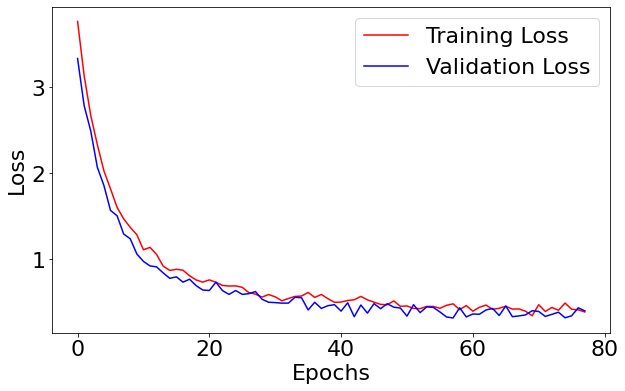

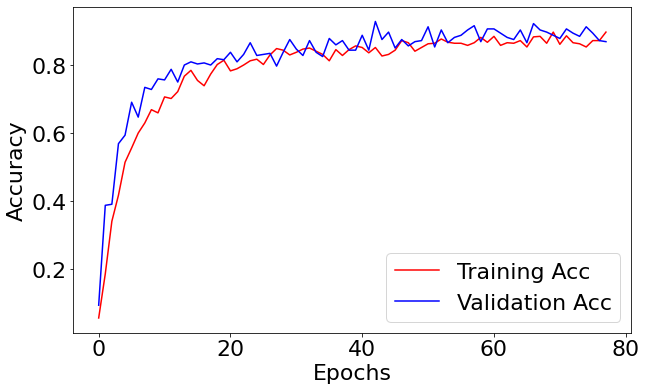

In [92]:
#Plot the Learning Curves from model training.
plot_training_curves(history)

###Convert to Tensorflow Lite and Quantize model.
 Converting the model to it's tensorflow lite equivalent and applying quantization provides better efficiency for the live detection on the Raspberry Pi.

 **Inference will be faster and it will need less memmory space to store model**.

In [95]:
#Load optimal weights computed during training.
model.load_weights(WEIGHTS_FILE)
#Convert the model to it's Tensorflow Lite equivalent
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT] ##Quantized
tflite_model = converter.convert()

# Save the model.
with open('model.tfliteQuant', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpgdzlfoff/assets


INFO:tensorflow:Assets written to: /tmp/tmpgdzlfoff/assets


####Scripts to save or restore the whole model. (OPTIONAL)

In [74]:
#Save the whole model for experimentations.
!mkdir -p saved_model 
model.save('saved_model/MobileNetV2') 

# my_model directory
!ls saved_model
# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/MobileNetV2
# Zip it before download (So that you can download the whole directory at once )
!zip  -r /content/MobileNetV2_In_Zip.zip /content/saved_model
print("Zip Ready")
# Download it 
files.download('/content/MobileNetV2_In_Zip.zip')

INFO:tensorflow:Assets written to: saved_model/MobileNetV2/assets


INFO:tensorflow:Assets written to: saved_model/MobileNetV2/assets


MobileNetV2
assets	saved_model.pb	variables
  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/MobileNetV2/ (stored 0%)
  adding: content/saved_model/MobileNetV2/assets/ (stored 0%)
  adding: content/saved_model/MobileNetV2/saved_model.pb (deflated 93%)
  adding: content/saved_model/MobileNetV2/variables/ (stored 0%)
  adding: content/saved_model/MobileNetV2/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/MobileNetV2/variables/variables.index (deflated 77%)
Zip Ready


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Restore an uploaded model for experimentations
files.upload()

!unzip -q /content/saved_model_In_Zip.zip 
new_model = tf.keras.models.load_model('/content/content/saved_model/MobileNetV2')
# Check its architecture
new_model.summary()

###Evaluate the model's performance.

In [93]:
#Load optimal weights computed during training.
model.load_weights(WEIGHTS_FILE)
eval=model.evaluate(valid_data)
print(eval)

550/550 [==============================] - 40s 72ms/step - loss: 0.2934 - accuracy: 0.9123
[0.29336366057395935, 0.9123036861419678]


In [94]:
#Get predictions on the test_dataset you define with TEST_PATH
test_model(TEST_PATH)



Actual class : PotatoEarlyBlight5.JPG
predicted class name->  MobileV2: Potato___Early_blight


Actual class : AppleScab1.JPG
predicted class name->  MobileV2: Apple___Apple_scab


Actual class : PotatoEarlyBlight3.JPG
predicted class name->  MobileV2: Potato___Late_blight


Actual class : PotatoEarlyBlight1.JPG
predicted class name->  MobileV2: Potato___Early_blight


Actual class : TomatoEarlyBlight3.JPG
predicted class name->  MobileV2: Tomato___Spider_mites Two-spotted_spider_mite


Actual class : TomatoYellowCurlVirus1.JPG
predicted class name->  MobileV2: Tomato___Tomato_Yellow_Leaf_Curl_Virus


Actual class : PotatoEarlyBlight2.JPG
predicted class name->  MobileV2: Potato___Early_blight


Actual class : TomatoYellowCurlVirus6.JPG
predicted class name->  MobileV2: Tomato___Tomato_Yellow_Leaf_Curl_Virus


Actual class : CornCommonRust1.JPG
predicted class name->  MobileV2: Corn_(maize)___Common_rust_


Actual class : TomatoHealthy2.JPG
predicted class name->  MobileV2: Tomato___

###Future Work

Try different optimizers ,batch-size, dropout-rates and base learning rate.